# **Bibliotecas e Funções**

In [1]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
# !pip install gdown==4.6.0 --quiet
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [4]:
%%capture

!gdown 129xV7F8XXr_4PqRtcR-GV7unEgNrL6qW --quiet # Sistema Digestório treino
!gdown 13aJGpxw_tAhT-44yuD-mRKjDsJcHwynU --quiet # Sistema Digestório teste

In [5]:
df_sist_dig_treino = pd.read_csv('/content/sist_dig_treino.csv')
print(df_sist_dig_treino.shape)
df_sist_dig_treino.head(3)

(97924, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.313399,-0.486452,0.889193,-0.855087,-0.933936,-0.777605,-1.053163,-1.057999,-0.846260,-0.052318,...,-0.702199,1.584652,0.669012,0.801956,-1.240717,0.520496,1.131402,2.122043,Boca,1
1,-0.775695,1.028664,0.875829,1.343451,-1.043802,1.054160,0.600930,-0.567847,-1.356322,-0.078540,...,-0.209650,-0.933152,-0.753735,0.794255,-0.968850,0.154944,0.964441,-0.475073,Colorretal,0
2,-0.815064,-0.486452,0.918482,-0.855087,1.070737,1.139022,-1.053163,0.945180,1.181669,-0.052318,...,0.732225,-0.949295,-0.763297,0.830259,0.464651,-1.748979,1.131402,-0.471244,Boca,0


In [6]:
df_sist_dig_teste = pd.read_csv('/content/sist_dig_teste.csv')
print(df_sist_dig_teste.shape)
df_sist_dig_teste.head(3)

(32645, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.214492,1.028664,0.916336,1.343451,0.958036,1.054160,-1.664088,-0.567847,0.737288,-0.078540,...,-1.353129,-0.392930,-0.518012,0.692936,-0.968850,-0.870779,-1.036870,-0.475073,Colorretal,0
1,0.765536,-0.438574,0.929651,-0.867646,0.756823,0.008932,-0.545489,-1.026325,-1.178694,-0.053606,...,1.263874,-0.949246,-0.790110,0.836351,-1.175867,-1.674465,1.112286,-0.399978,Esôfago,0
2,0.773540,-0.486452,0.545758,1.148151,1.070737,-0.298449,-1.053163,0.945180,1.181669,-0.052318,...,-1.598714,0.679671,1.146449,-0.486755,-1.240717,-0.614241,-0.883859,-0.471244,Boca,1


In [7]:
# DFs de teste para cada tipo
boca_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Boca']
oro_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Orofaringe']
eso_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Esôfago']
esto_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Estômago']
delg_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Delgado']
colo_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Colorretal']
anus_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Ânus']

boca_teste.shape, oro_teste.shape, eso_teste.shape, esto_teste.shape, delg_teste.shape, colo_teste.shape, anus_teste.shape

((5984, 25),
 (1231, 25),
 (3491, 25),
 (6943, 25),
 (399, 25),
 (14028, 25),
 (569, 25))

# **Sistema Digestório Juntos**

## **Pré-processamento**

In [8]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_sist_dig_treino['TOPOGRUP'] = oe.fit_transform(df_sist_dig_treino[['TOPOGRUP']])
df_sist_dig_teste['TOPOGRUP'] = oe.transform(df_sist_dig_teste[['TOPOGRUP']])

ss = StandardScaler()
df_sist_dig_treino['TOPOGRUP'] = ss.fit_transform(df_sist_dig_treino[['TOPOGRUP']])
df_sist_dig_teste['TOPOGRUP'] = ss.transform(df_sist_dig_teste[['TOPOGRUP']])

In [9]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df_sist_dig_treino.drop(columns=list_drop).copy()
y_train = df_sist_dig_treino.sobrevida_3anos.copy()

# Teste
X_test = df_sist_dig_teste.drop(columns=list_drop).copy()
y_test = df_sist_dig_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((97924, 24), (97924,), (32645, 24), (32645,))

In [10]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

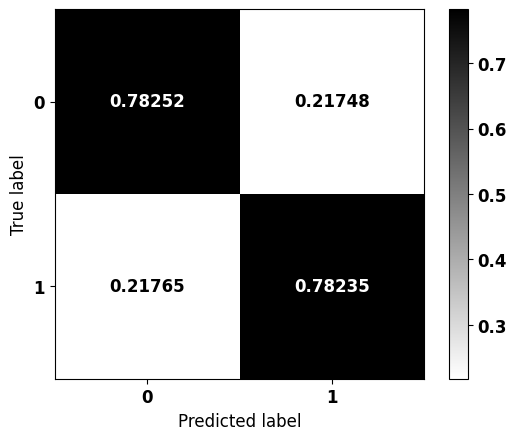


              precision    recall  f1-score   support

           0    0.83827   0.78252   0.80943     19275
           1    0.71390   0.78235   0.74656     13370

    accuracy                        0.78245     32645
   macro avg    0.77608   0.78243   0.77800     32645
weighted avg    0.78733   0.78245   0.78368     32645



In [11]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=1.31,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

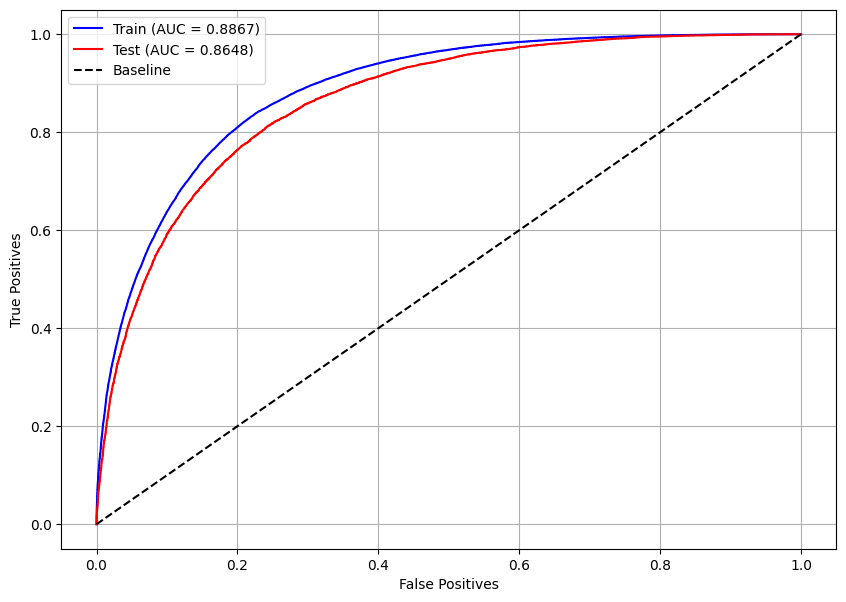

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

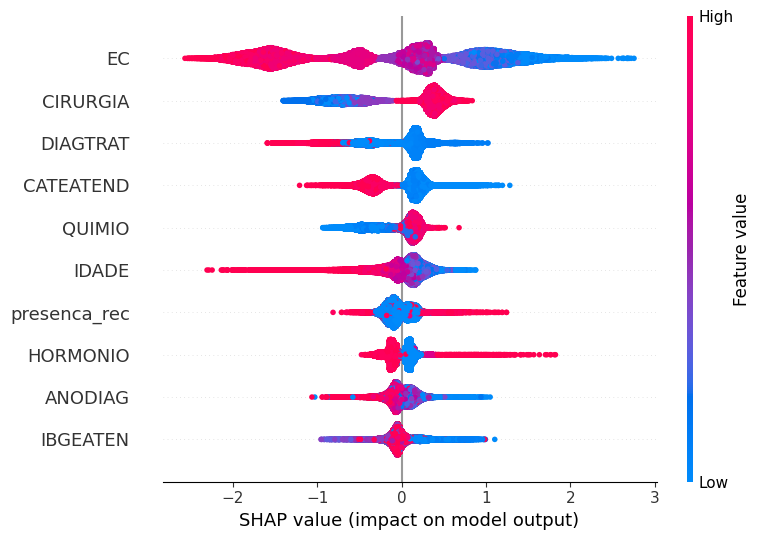

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 86,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.29, 1.32, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

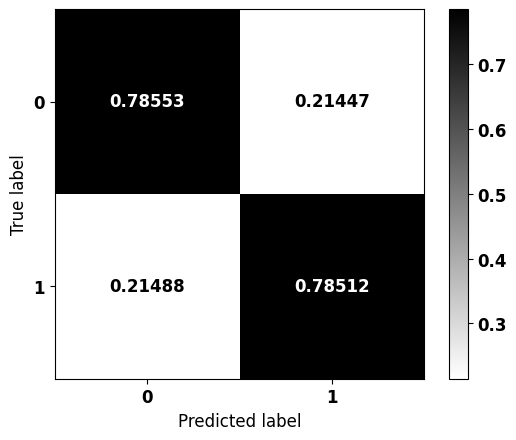


              precision    recall  f1-score   support

           0    0.84051   0.78553   0.81209     19275
           1    0.71745   0.78512   0.74976     13370

    accuracy                        0.78536     32645
   macro avg    0.77898   0.78532   0.78092     32645
weighted avg    0.79011   0.78536   0.78656     32645



In [13]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.2968

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

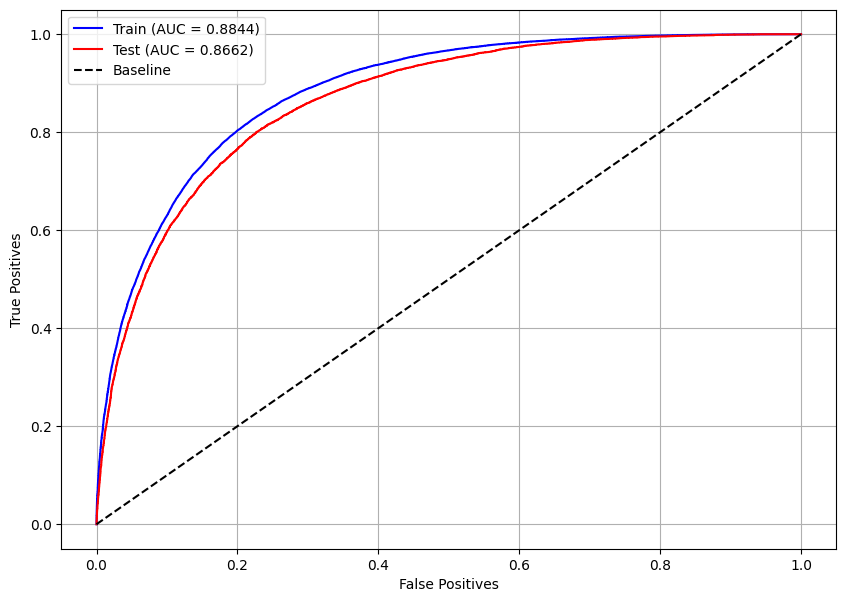

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 106,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(1.295, 1.33, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

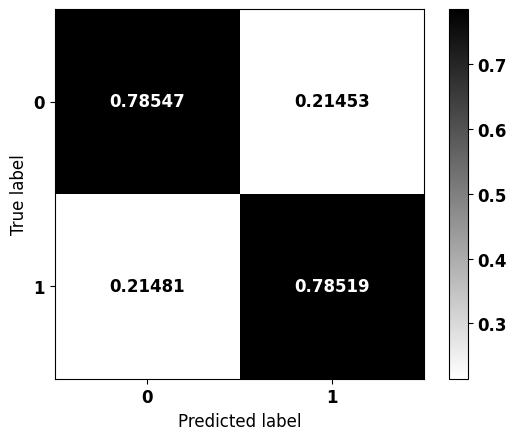


              precision    recall  f1-score   support

           0    0.84055   0.78547   0.81208     19275
           1    0.71742   0.78519   0.74978     13370

    accuracy                        0.78536     32645
   macro avg    0.77899   0.78533   0.78093     32645
weighted avg    0.79012   0.78536   0.78656     32645



In [15]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.2995

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

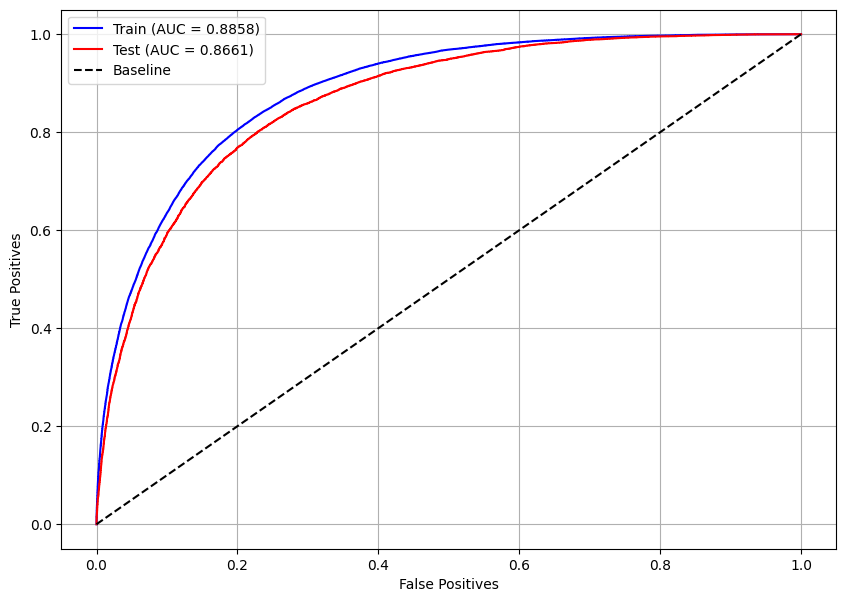

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 115,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.295, 1.32, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

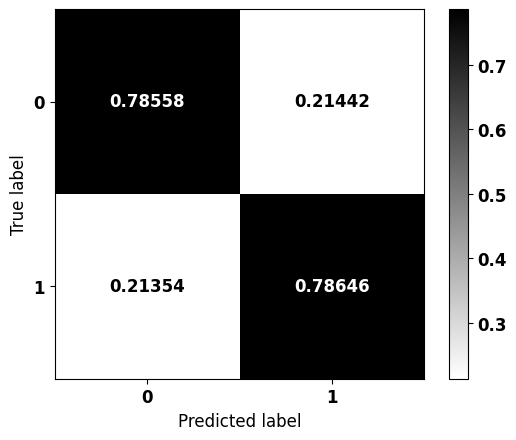


              precision    recall  f1-score   support

           0    0.84136   0.78558   0.81251     19275
           1    0.71785   0.78646   0.75059     13370

    accuracy                        0.78594     32645
   macro avg    0.77960   0.78602   0.78155     32645
weighted avg    0.79078   0.78594   0.78715     32645



In [17]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.3091

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

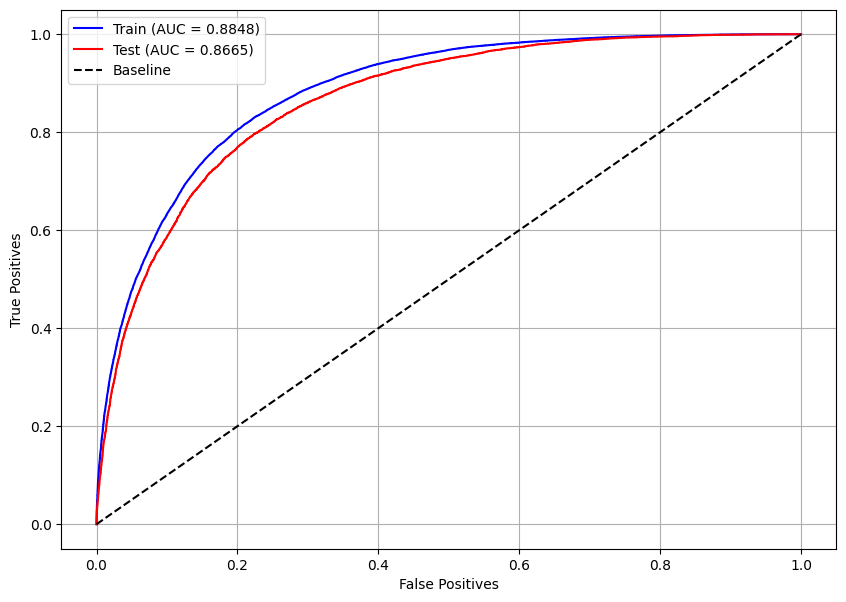

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [18]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=115, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


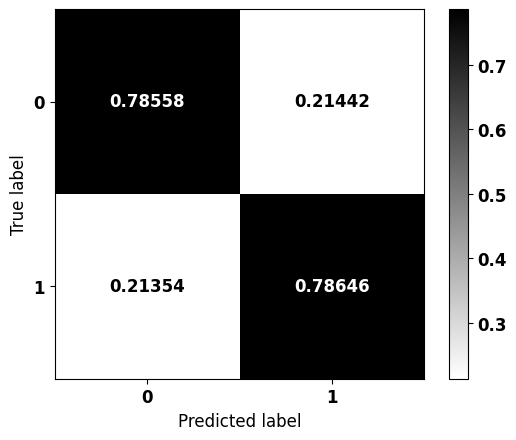


              precision    recall  f1-score   support

           0    0.84136   0.78558   0.81251     19275
           1    0.71785   0.78646   0.75059     13370

    accuracy                        0.78594     32645
   macro avg    0.77960   0.78602   0.78155     32645
weighted avg    0.79078   0.78594   0.78715     32645



In [19]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

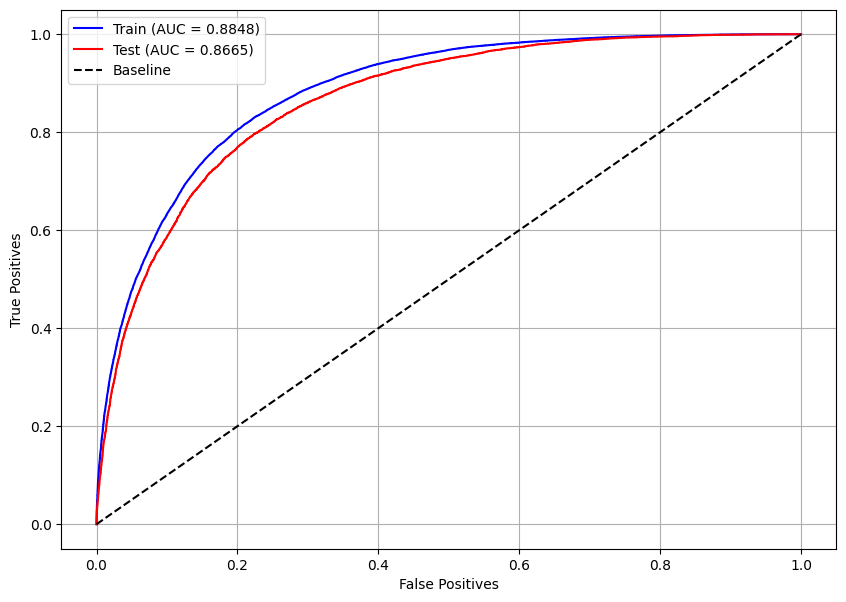

In [20]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

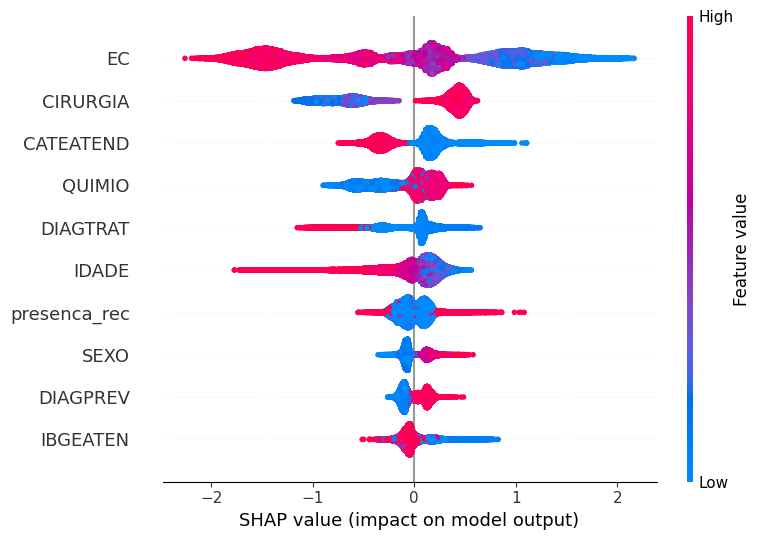

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

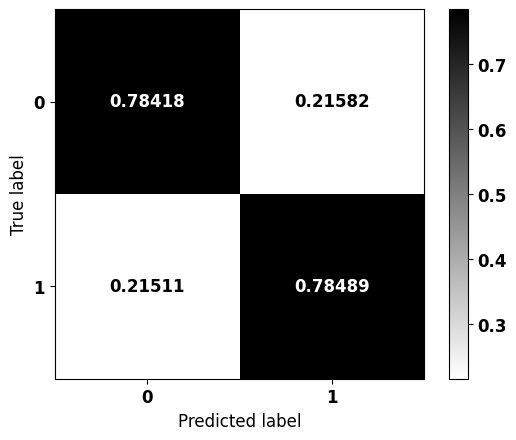


              precision    recall  f1-score   support

           0    0.84014   0.78418   0.81120     19275
           1    0.71612   0.78489   0.74893     13370

    accuracy                        0.78447     32645
   macro avg    0.77813   0.78453   0.78006     32645
weighted avg    0.78935   0.78447   0.78569     32645



In [21]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.29},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

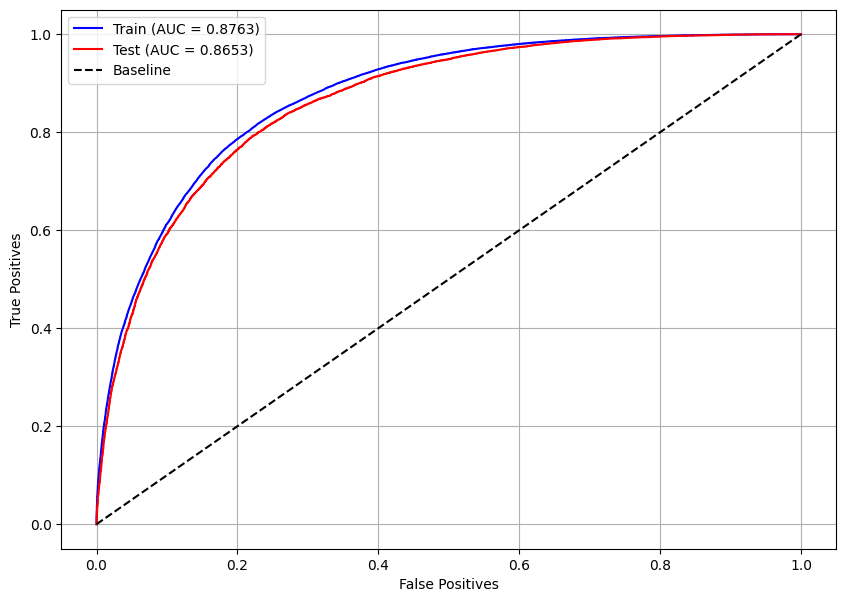

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


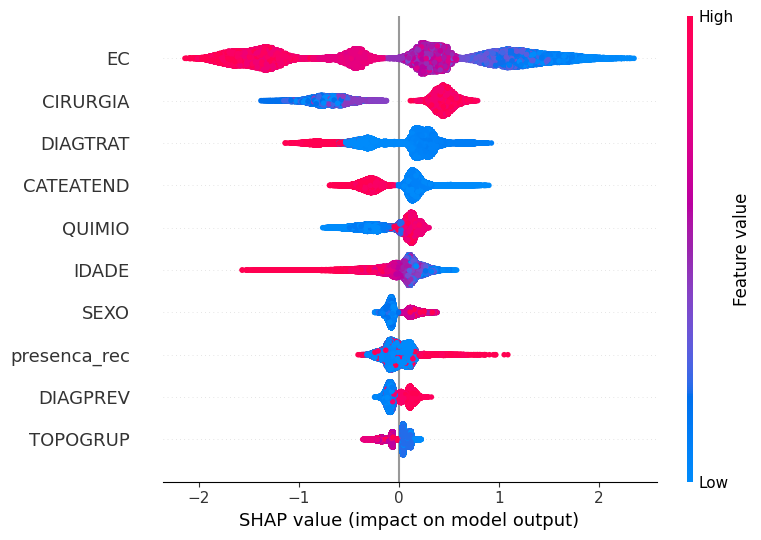

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 133,
 'max_depth': 10,
 'learning_rate': 0.14,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.295, 1.315, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

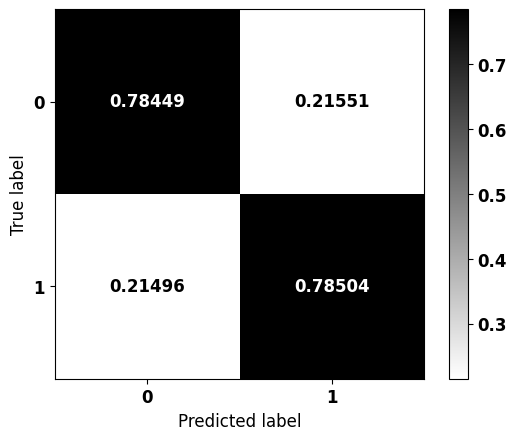


              precision    recall  f1-score   support

           0    0.84029   0.78449   0.81143     19275
           1    0.71645   0.78504   0.74918     13370

    accuracy                        0.78471     32645
   macro avg    0.77837   0.78476   0.78030     32645
weighted avg    0.78957   0.78471   0.78593     32645



In [23]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.2958}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

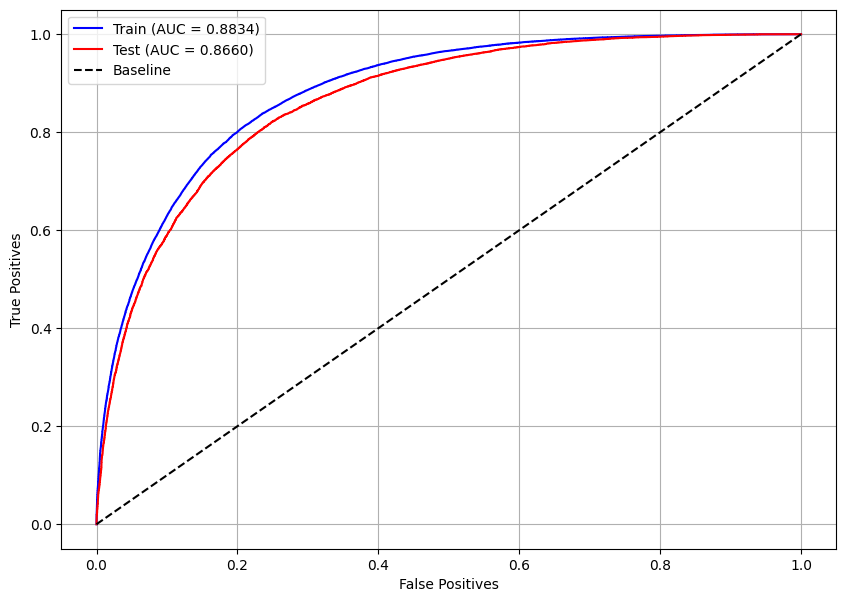

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 124,
 'max_depth': 9,
 'learning_rate': 0.16,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.29, 1.315, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

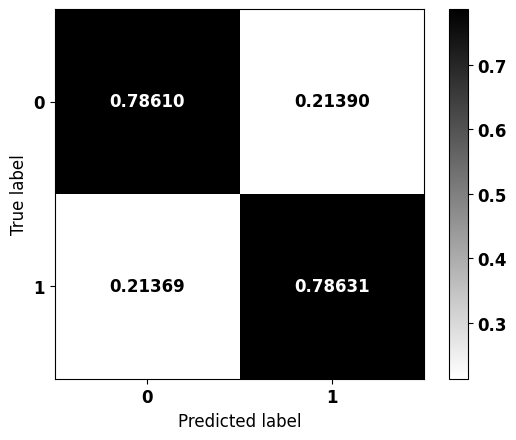


              precision    recall  f1-score   support

           0    0.84136   0.78610   0.81279     19275
           1    0.71830   0.78631   0.75077     13370

    accuracy                        0.78618     32645
   macro avg    0.77983   0.78620   0.78178     32645
weighted avg    0.79096   0.78618   0.78739     32645



In [25]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3032}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

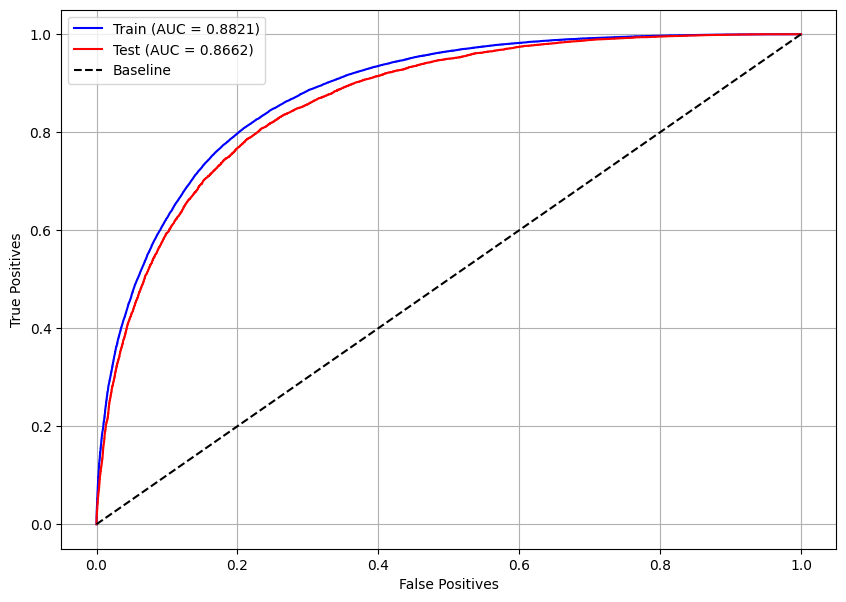

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 133,
 'max_depth': 8,
 'learning_rate': 0.14,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.285, 1.315, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

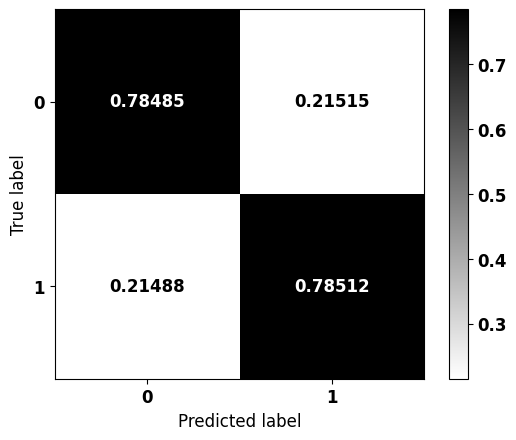


              precision    recall  f1-score   support

           0    0.84040   0.78485   0.81168     19275
           1    0.71681   0.78512   0.74941     13370

    accuracy                        0.78496     32645
   macro avg    0.77861   0.78498   0.78054     32645
weighted avg    0.78978   0.78496   0.78617     32645



In [27]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3006}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

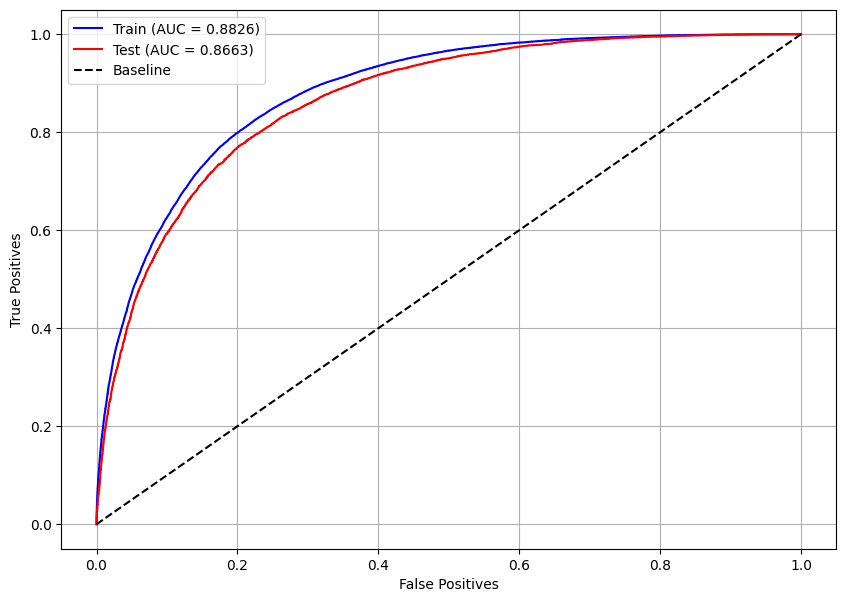

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [28]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.3032}, colsample_bytree=0.4,
               learning_rate=0.16, max_depth=9, min_child_weight=6,
               n_estimators=124, random_state=7, verbose=-1)


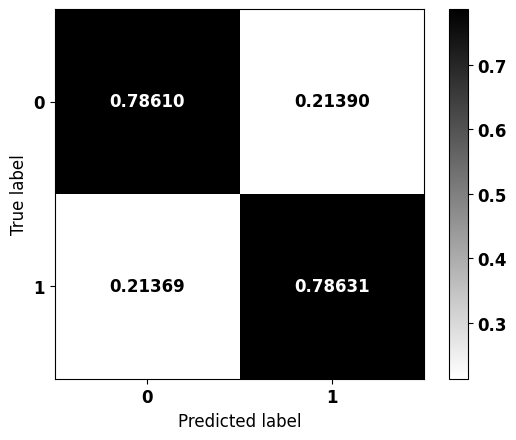


              precision    recall  f1-score   support

           0    0.84136   0.78610   0.81279     19275
           1    0.71830   0.78631   0.75077     13370

    accuracy                        0.78618     32645
   macro avg    0.77983   0.78620   0.78178     32645
weighted avg    0.79096   0.78618   0.78739     32645



In [29]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

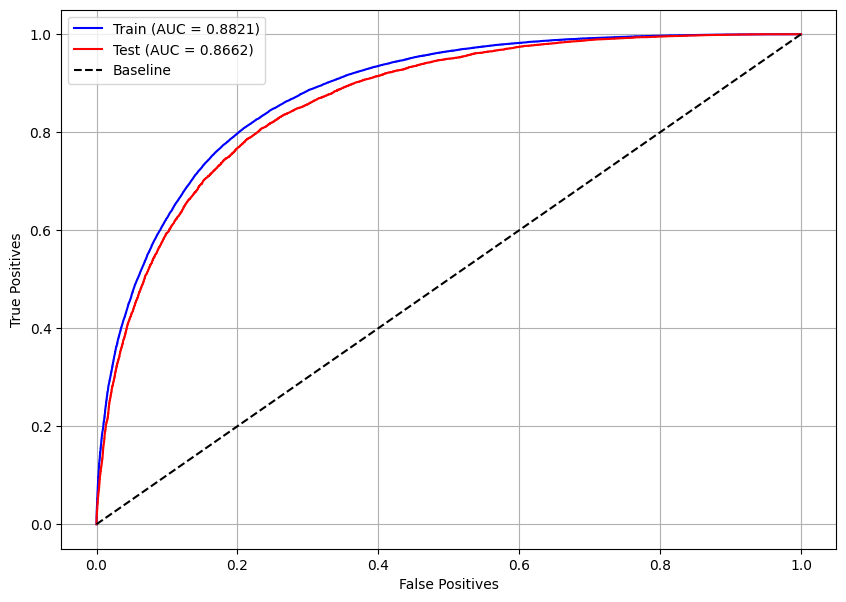

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

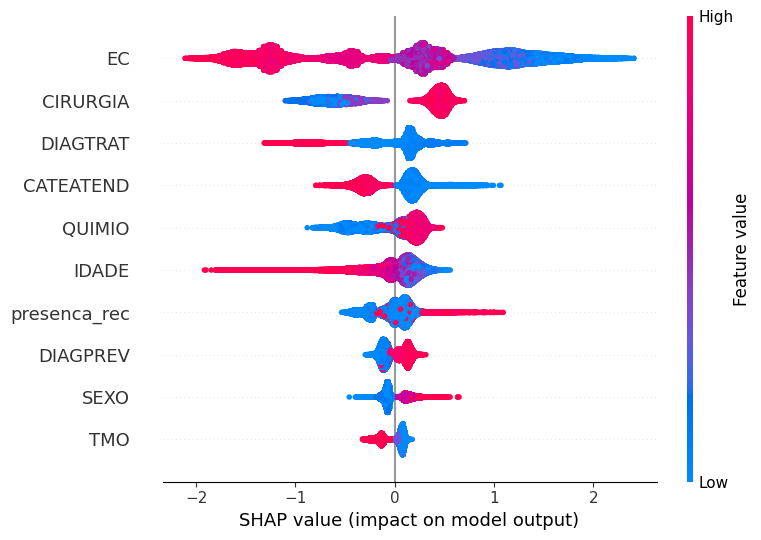

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Testes cruzados**

In [30]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.3032}, colsample_bytree=0.4,
               learning_rate=0.16, max_depth=9, min_child_weight=6,
               n_estimators=124, random_state=7, verbose=-1)


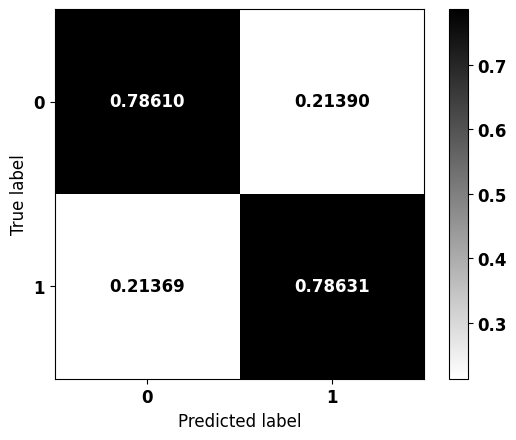


              precision    recall  f1-score   support

           0    0.84136   0.78610   0.81279     19275
           1    0.71830   0.78631   0.75077     13370

    accuracy                        0.78618     32645
   macro avg    0.77983   0.78620   0.78178     32645
weighted avg    0.79096   0.78618   0.78739     32645



In [31]:
plot_confusion_matrix(best, X_test, y_test)

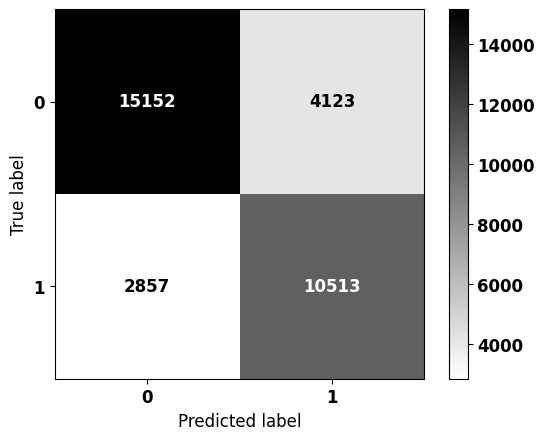


              precision    recall  f1-score   support

           0    0.84136   0.78610   0.81279     19275
           1    0.71830   0.78631   0.75077     13370

    accuracy                        0.78618     32645
   macro avg    0.77983   0.78620   0.78178     32645
weighted avg    0.79096   0.78618   0.78739     32645



In [32]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

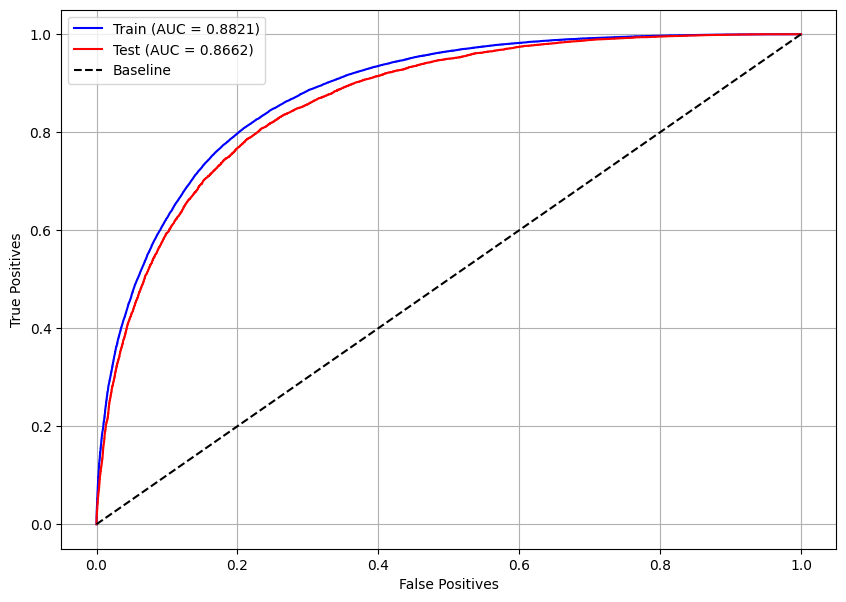

In [33]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(best, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


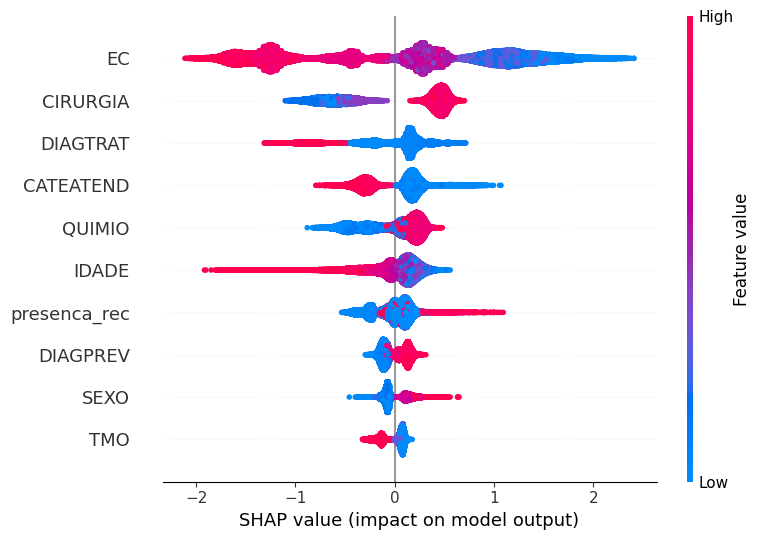

In [34]:
# Importância das features pelos valores SHAP
plot_shap_values(best, X_train, feat_cols)

In [ ]:
dfs = [boca_teste, colo_teste, oro_teste, eso_teste, esto_teste, anus_teste, delg_teste]

for i, df in enumerate(dfs):
    df['TOPOGRUP'] = oe.transform(df[['TOPOGRUP']])
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

In [36]:
# Cavidade Oral
X_test_boca = boca_teste.drop(columns=list_drop).copy()
y_test_boca = boca_teste.sobrevida_3anos.copy()

# Orofaringe
X_test_oro = oro_teste.drop(columns=list_drop).copy()
y_test_oro = oro_teste.sobrevida_3anos.copy()

# Esôfago
X_test_eso = eso_teste.drop(columns=list_drop).copy()
y_test_eso = eso_teste.sobrevida_3anos.copy()

# Estômago
X_test_esto = esto_teste.drop(columns=list_drop).copy()
y_test_esto = esto_teste.sobrevida_3anos.copy()

# Intestino Delgado
X_test_delg = delg_teste.drop(columns=list_drop).copy()
y_test_delg = delg_teste.sobrevida_3anos.copy()

# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

# Ânus
X_test_anus = anus_teste.drop(columns=list_drop).copy()
y_test_anus = anus_teste.sobrevida_3anos.copy()

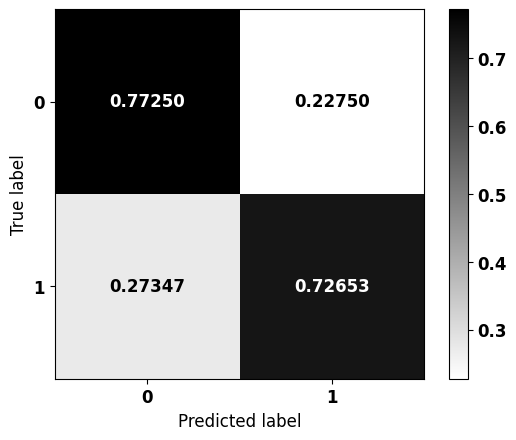


              precision    recall  f1-score   support

           0    0.80294   0.77250   0.78742      3534
           1    0.68885   0.72653   0.70719      2450

    accuracy                        0.75368      5984
   macro avg    0.74590   0.74951   0.74731      5984
weighted avg    0.75623   0.75368   0.75457      5984



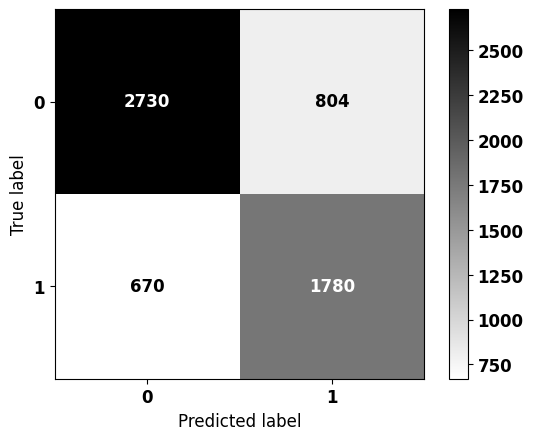


              precision    recall  f1-score   support

           0    0.80294   0.77250   0.78742      3534
           1    0.68885   0.72653   0.70719      2450

    accuracy                        0.75368      5984
   macro avg    0.74590   0.74951   0.74731      5984
weighted avg    0.75623   0.75368   0.75457      5984



In [37]:
# Cavidade Oral
plot_confusion_matrix(best, X_test_boca, y_test_boca)
plot_confusion_matrix(best, X_test_boca, y_test_boca, norm=False)

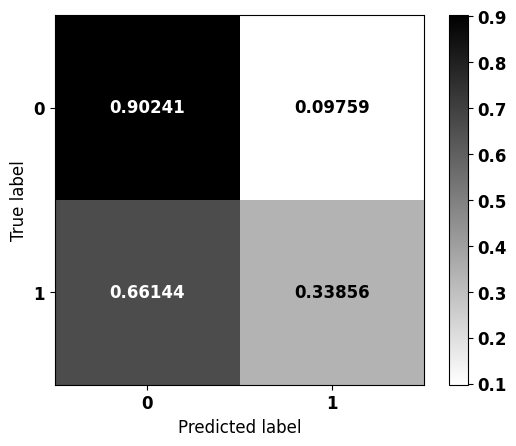


              precision    recall  f1-score   support

           0    0.79594   0.90241   0.84584       912
           1    0.54822   0.33856   0.41860       319

    accuracy                        0.75630      1231
   macro avg    0.67208   0.62049   0.63222      1231
weighted avg    0.73175   0.75630   0.73512      1231



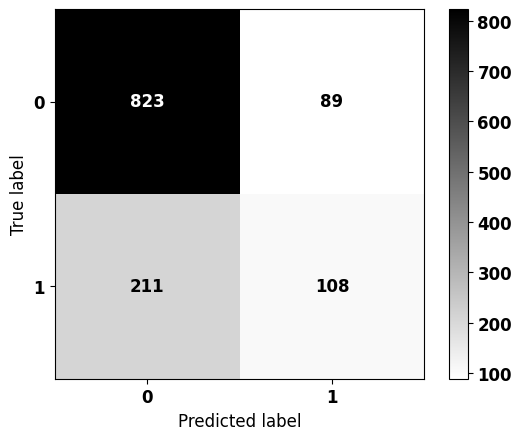


              precision    recall  f1-score   support

           0    0.79594   0.90241   0.84584       912
           1    0.54822   0.33856   0.41860       319

    accuracy                        0.75630      1231
   macro avg    0.67208   0.62049   0.63222      1231
weighted avg    0.73175   0.75630   0.73512      1231



In [38]:
# Orofaringe
plot_confusion_matrix(best, X_test_oro, y_test_oro)
plot_confusion_matrix(best, X_test_oro, y_test_oro, norm=False)

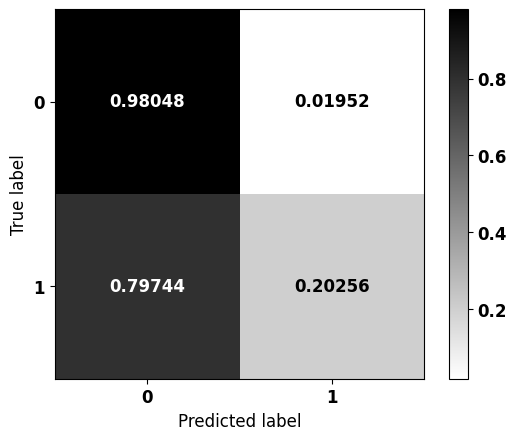


              precision    recall  f1-score   support

           0    0.88792   0.98048   0.93191      3022
           1    0.61688   0.20256   0.30498       469

    accuracy                        0.87597      3491
   macro avg    0.75240   0.59152   0.61844      3491
weighted avg    0.85151   0.87597   0.84768      3491



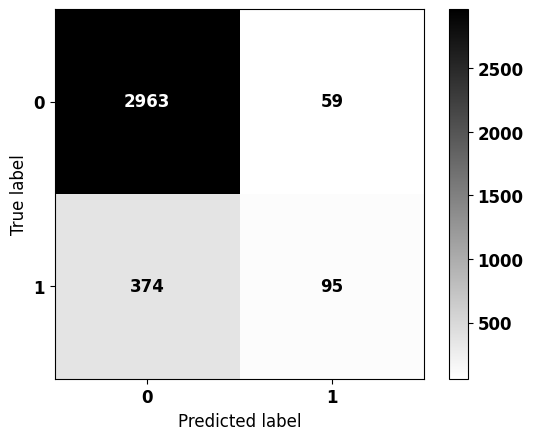


              precision    recall  f1-score   support

           0    0.88792   0.98048   0.93191      3022
           1    0.61688   0.20256   0.30498       469

    accuracy                        0.87597      3491
   macro avg    0.75240   0.59152   0.61844      3491
weighted avg    0.85151   0.87597   0.84768      3491



In [39]:
# Esôfago
plot_confusion_matrix(best, X_test_eso, y_test_eso)
plot_confusion_matrix(best, X_test_eso, y_test_eso, norm=False)

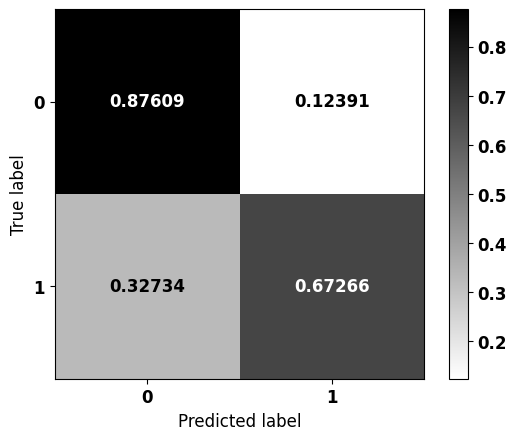


              precision    recall  f1-score   support

           0    0.87730   0.87609   0.87670      5052
           1    0.67018   0.67266   0.67142      1891

    accuracy                        0.82068      6943
   macro avg    0.77374   0.77437   0.77406      6943
weighted avg    0.82089   0.82068   0.82079      6943



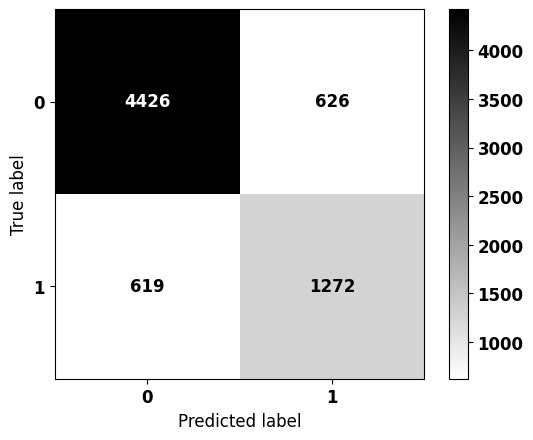


              precision    recall  f1-score   support

           0    0.87730   0.87609   0.87670      5052
           1    0.67018   0.67266   0.67142      1891

    accuracy                        0.82068      6943
   macro avg    0.77374   0.77437   0.77406      6943
weighted avg    0.82089   0.82068   0.82079      6943



In [40]:
# Estômago
plot_confusion_matrix(best, X_test_esto, y_test_esto)
plot_confusion_matrix(best, X_test_esto, y_test_esto, norm=False)

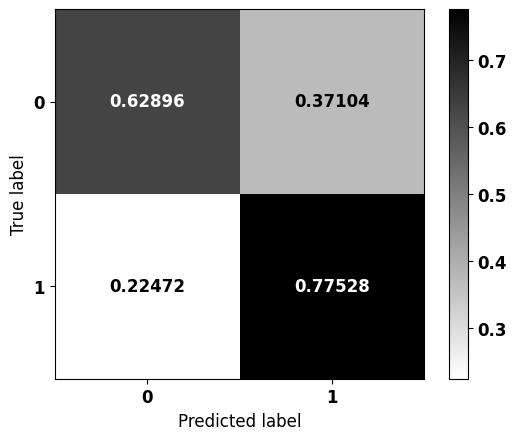


              precision    recall  f1-score   support

           0    0.77654   0.62896   0.69500       221
           1    0.62727   0.77528   0.69347       178

    accuracy                        0.69424       399
   macro avg    0.70190   0.70212   0.69423       399
weighted avg    0.70995   0.69424   0.69432       399



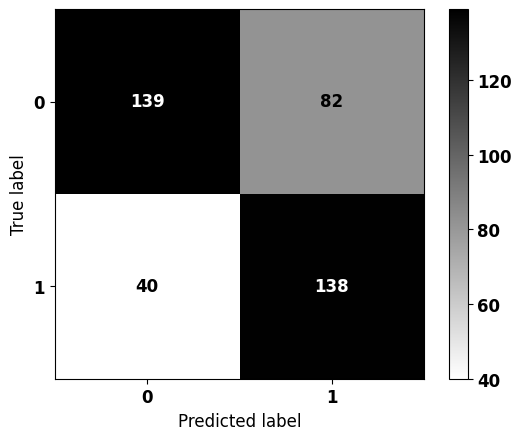


              precision    recall  f1-score   support

           0    0.77654   0.62896   0.69500       221
           1    0.62727   0.77528   0.69347       178

    accuracy                        0.69424       399
   macro avg    0.70190   0.70212   0.69423       399
weighted avg    0.70995   0.69424   0.69432       399



In [41]:
# Intestino Delgado
plot_confusion_matrix(best, X_test_delg, y_test_delg)
plot_confusion_matrix(best, X_test_delg, y_test_delg, norm=False)

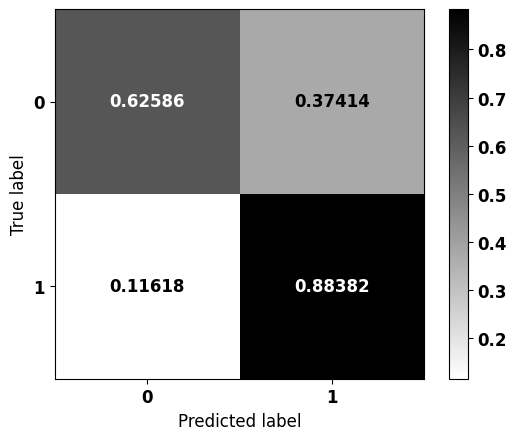


              precision    recall  f1-score   support

           0    0.81334   0.62586   0.70739      6273
           1    0.74492   0.88382   0.80845      7755

    accuracy                        0.76846     14028
   macro avg    0.77913   0.75484   0.75792     14028
weighted avg    0.77552   0.76846   0.76325     14028



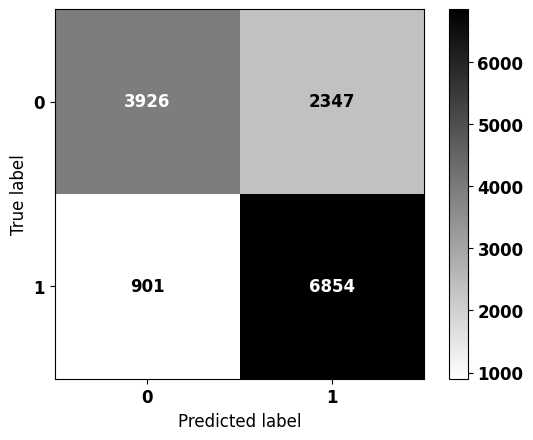


              precision    recall  f1-score   support

           0    0.81334   0.62586   0.70739      6273
           1    0.74492   0.88382   0.80845      7755

    accuracy                        0.76846     14028
   macro avg    0.77913   0.75484   0.75792     14028
weighted avg    0.77552   0.76846   0.76325     14028



In [42]:
# Colorretal
plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

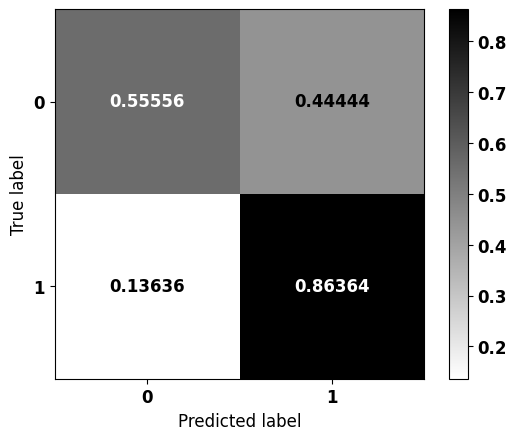


              precision    recall  f1-score   support

           0    0.77540   0.55556   0.64732       261
           1    0.69634   0.86364   0.77101       308

    accuracy                        0.72232       569
   macro avg    0.73587   0.70960   0.70917       569
weighted avg    0.73260   0.72232   0.71428       569



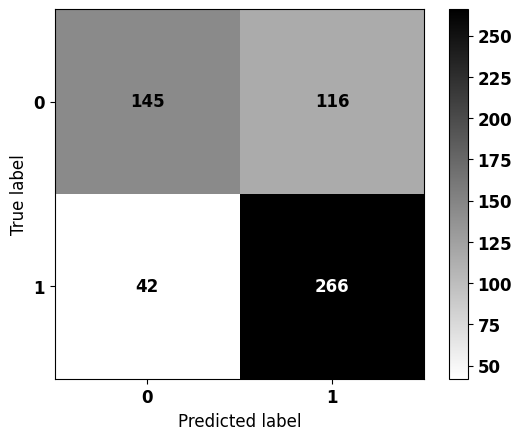


              precision    recall  f1-score   support

           0    0.77540   0.55556   0.64732       261
           1    0.69634   0.86364   0.77101       308

    accuracy                        0.72232       569
   macro avg    0.73587   0.70960   0.70917       569
weighted avg    0.73260   0.72232   0.71428       569



In [43]:
# Ânus
plot_confusion_matrix(best, X_test_anus, y_test_anus)
plot_confusion_matrix(best, X_test_anus, y_test_anus, norm=False)

## **Voting Classifier**


In [44]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7824, Optuna = 0.7859

Otimizado venceu


In [45]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7845, Optuna = 0.7862

Otimizado venceu


In [46]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 1.3032}, colsample_bytree=0.4,
               learning_rate=0.16, max_depth=9, min_child_weight=6,
               n_estimators=124, random_state=7, verbose=-1)

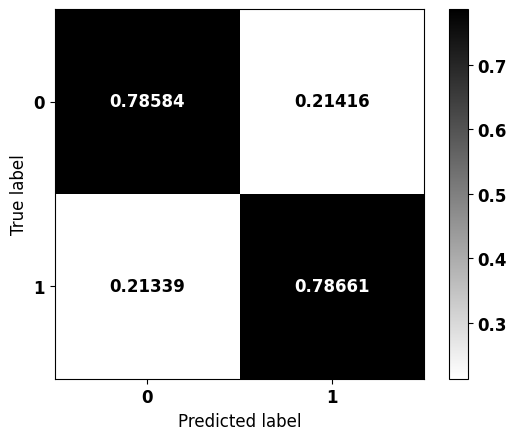


              precision    recall  f1-score   support

           0    0.84150   0.78584   0.81272     19275
           1    0.71813   0.78661   0.75081     13370

    accuracy                        0.78615     32645
   macro avg    0.77981   0.78622   0.78176     32645
weighted avg    0.79097   0.78615   0.78736     32645



In [47]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

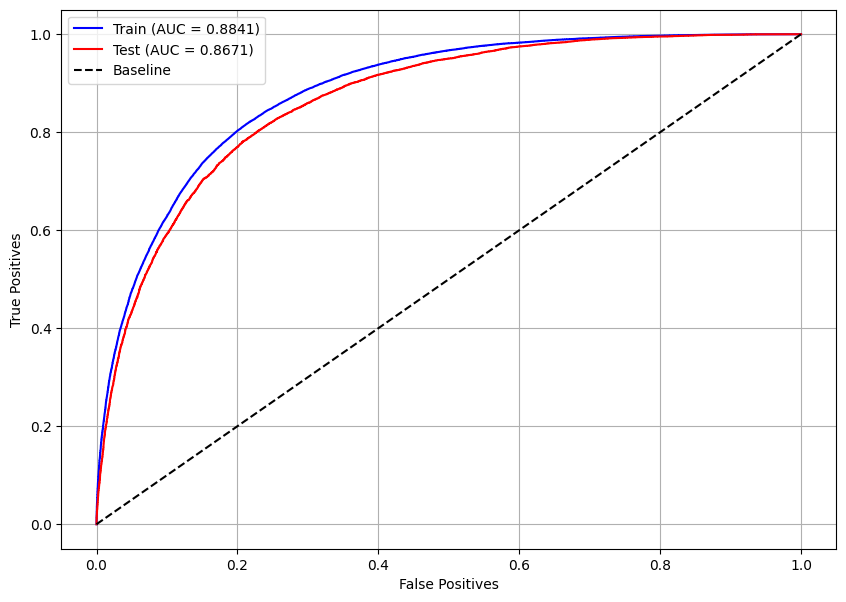

In [48]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)